In [79]:
import full_nuclide_ap21
import full_nuclide_ap21_r
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pynucastro as pyna

In [80]:
def plot(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(network.nnuc):
        ax.loglog(sol.t, sol.y[i,:] * network.A[i], label=f"X({network.names[i].capitalize()})") 
                 

    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.e-10, 1.0)
    ax.legend(fontsize="small")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

def composition(network):
    
    X0 = np.zeros(network.nnuc)
    X0[network.jco55] = 0.0
    X0[network.jn] = 1.0
    X0[network.jcr48] = 3.4
    X0[network.jfe52] = 0.0
    X0[network.jhe4] = 1.0
    X0[network.jmn51] = 0.0
    X0[network.jni56] = 1.0
    X0[network.jcr56] = 0.0
    X0[network.jfe54] = 0.0
    X0[network.jfe55] = 0.0
    X0[network.jfe56] = 0.0
    X0[network.jmn56] = 0.0
    X0[network.jp] = 1.0
    X0[network.jfe53] = 0.0
    X0[network.jmn52] = 0.0
    X0[network.jco56] = 0.0
    X0[network.jcr49] = 0.0
    
    X0[network.jmn55] = 0.0
    X0[network.jmn54] = 0.0
    X0[network.jmn53] = 0.0
    X0[network.jcr55] = 0.0
    
    
    X0 /= np.sum(X0)
    Y0 = X0/network.A

    return Y0

def compare(tmin, tmax, sol, sol_r, network, network_r, outfile='test'):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(4):
        ax.loglog(sol.t, sol.y[i,:] * network.A[i], label=f"X({network.names[i].capitalize()})_derived",
                  linestyle="solid", color=f"C{i}", linewidth=2)
        ax.loglog(sol_r.t, sol_r.y[i,:] * network_r.A[i], label=f"X({network_r.names[i].capitalize()})_reaclib", 
                  linestyle="None", color=f"C{i}", marker='o',  markersize=2)

    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.e-5, 1.0)
    ax.legend(fontsize="small")
    ax.set_title(r"Comparison between DerivedRate and pure ReacLib reaction networks")
    ax.set_xlabel(r"time [s]")
    ax.set_ylabel(r"molar fractions")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

In [81]:
Y0 = composition(full_nuclide_ap21)
rho = 1.0e8
T = 7.0e9
tmax = 1.0e-8
tmin = 1.0e-15

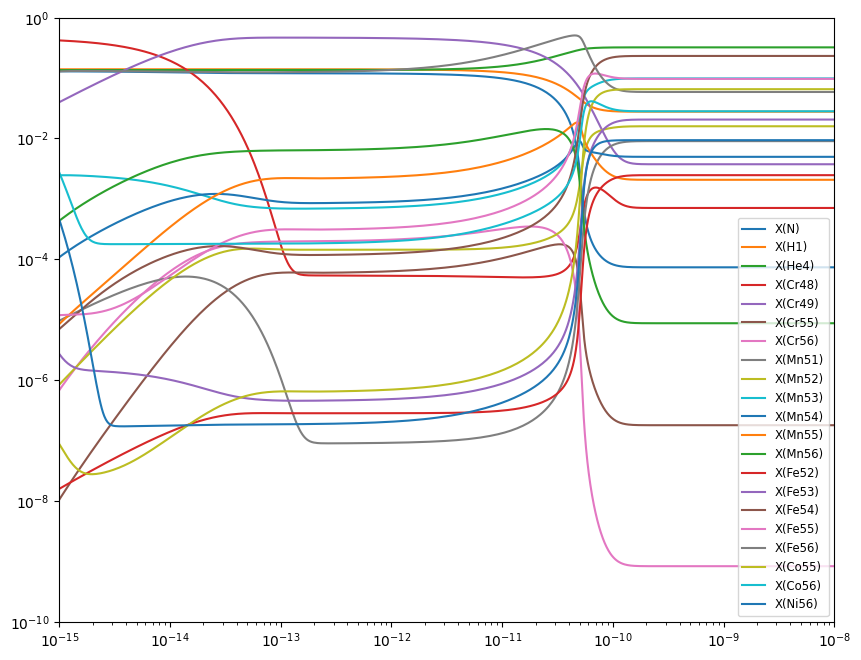

In [82]:
sol =  solve_ivp(full_nuclide_ap21.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-10, atol=1.e-10, jac=full_nuclide_ap21.jacobian)

plot(tmin=tmin, tmax=tmax, sol=sol, network=full_nuclide_ap21, outfile='derived_rho_{:.2e}_T_{:.2e}.png'.format(rho,T))


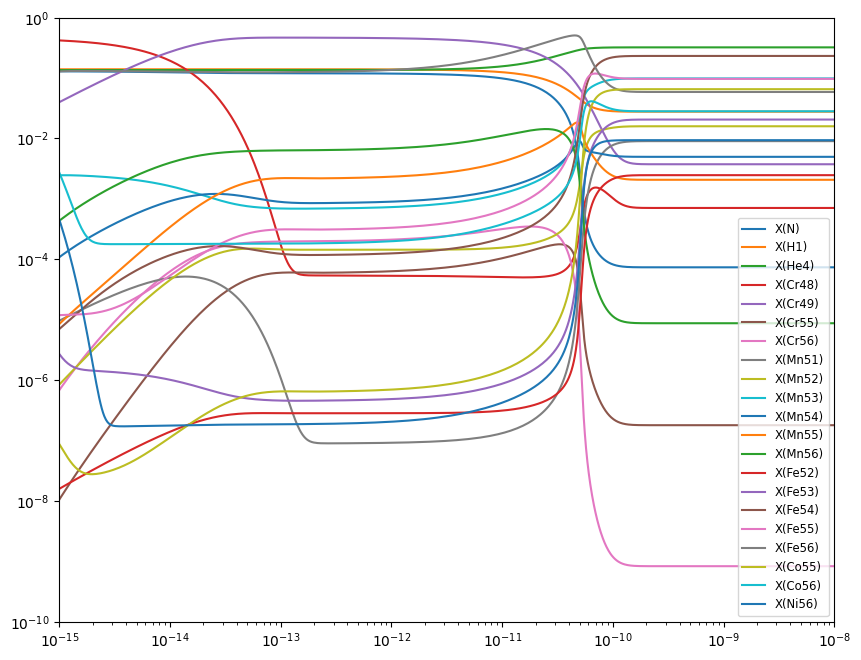

In [83]:
sol_r =  solve_ivp(full_nuclide_ap21_r.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-10, atol=1.e-10, jac=full_nuclide_ap21_r.jacobian)

plot(tmin=tmin, tmax=tmax, sol=sol_r, network=full_nuclide_ap21_r, outfile='reaclib_rho_{:.2e}_T_{:.2e}.png'.format(rho,T))

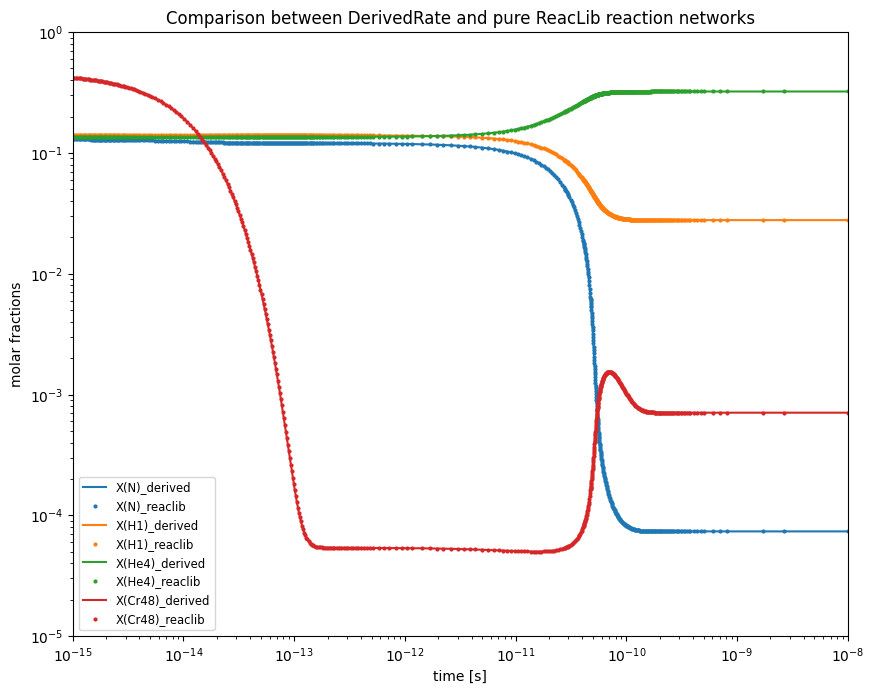

In [84]:
compare(tmin, tmax, sol, sol_r, full_nuclide_ap21, full_nuclide_ap21_r)